<a href="https://colab.research.google.com/github/GoetheUniCV/cvproject/blob/main/visualization/gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Grad-CAM

In [72]:
from google.colab import drive
import tensorflow as tf
import numpy as np
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# This mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# Foldername in your Drive where you have saved the COVID-19 data.
PROJECT_PATH = '/content/drive/My Drive/cvproject/'
DATABASE_PATH = f'{PROJECT_PATH}/COVID-19 Radiography Database'
MODELS_PATH = f'{PROJECT_PATH}/models'

Mounted at /content/drive


In [64]:
model = tf.keras.models.load_model(f'{MODELS_PATH}/model_2020-12-28.h5')

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 244, 244, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 128)       7

In [65]:
# Show label name and its encoded value:
class_names =  ["COVID-19","NORMAL","Viral Pneumonia"]

for i, class_name in enumerate(class_names):
    print(f'{class_name}: {i}')

COVID-19: 0
NORMAL: 1
Viral Pneumonia: 2


In [55]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 3829 files belonging to 3 classes.
Using 765 files for validation.


In [59]:
z = 0
for batch in test_data:
  for image in batch:
    z += 1
z

48

In [85]:
img_size = (244, 244)

last_conv_layer_name = "dropout_1"
classifier_layer_names = [
    "flatten",
    "dense",
    "dropout_2",
    "dense_1",
]

In [62]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [105]:
heatmaps = []
# iterate the buckets
for images, labels in test_data.take(-1):  # only take first element of dataset; change to -1 for all buckets!
  images_np = images.numpy()
  labels_np = labels.numpy()

  # Get the covid images of the current bucket.
  images_covid_np = images_np[labels_np == 0]

  for image in images_covid_np:
    image_array = np.expand_dims(image, axis=0)

    # Print what the top predicted class is.
    preds = model.predict(image_array)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name, classifier_layer_names)

    heatmaps.append([image, heatmap])

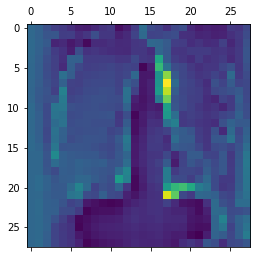

In [94]:
plt.matshow(heatmaps[0][1])
plt.show()

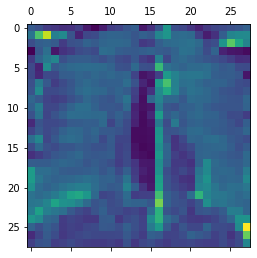

In [99]:
plt.matshow(heatmaps[1][1])
plt.show()

In [104]:
len(heatmaps)

10

TODO: Heatmap inside image

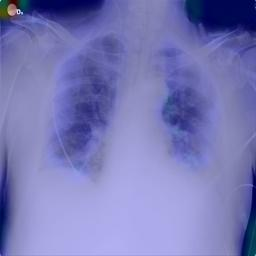

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
